<a href="https://colab.research.google.com/github/AnshumanAryan24/22BCE0219-BCSE206L-Project/blob/main/notebooks/BCSE206L_variable_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession  # For SQL over pandas.DataFrame

## Loading and preocessing

In [4]:
data = pd.read_csv('/content/Fertility2_preprocessed.csv')
data.columns

Index(['Unnamed: 0', 'gender1', 'gender2', 'age', 'afam', 'hispanic', 'other',
       'morekids', 'work'],
      dtype='object')

In [13]:
data = data.drop('Unnamed: 0', axis=1)

In [14]:
data.head()

,gender1,gender2,age,afam,hispanic,other,morekids,work
0,0,0,35,0,0,0,0,40
1,0,1,33,0,0,0,0,52
2,0,0,28,0,0,0,0,12
3,1,1,28,0,0,0,0,0
4,0,1,31,0,0,0,0,0


In [15]:
X = data[['gender1', 'gender2', 'age', 'afam', 'hispanic', 'other']]
y = data['morekids']

In [7]:
spark = SparkSession.builder.appName('SQLonDataFrame').getOrCreate()

In [16]:
df = spark.createDataFrame(data)
df.createOrReplaceTempView('data')
spark.sql("desc data").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
| gender1|   bigint|   NULL|
| gender2|   bigint|   NULL|
|     age|   bigint|   NULL|
|    afam|   bigint|   NULL|
|hispanic|   bigint|   NULL|
|   other|   bigint|   NULL|
|morekids|   bigint|   NULL|
|    work|   bigint|   NULL|
+--------+---------+-------+



## Variable Analysis

Fit a logistic regression model over the dataset to analyse which variables contribute most to the model's performance.<br>
Take p<0.05 to be most significant variables.

In [17]:
import statsmodels.api as sm

# Add constant intercept X to calculate the baseline
X_const = sm.add_constant(X)

model = sm.Logit(y, X_const)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.652431
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               morekids   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29993
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                 0.01576
Time:                        19:18:53   Log-Likelihood:                -19573.
converged:                       True   LL-Null:                       -19886.
Covariance Type:            nonrobust   LLR p-value:                3.992e-132
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7418      0.114    -24.004      0.000      -2.966      -2.518
gender1       -0.0208      0.

In [19]:
# Plotting graph for variation with age
import numpy as np

# Create 100 age values from min to max in given dataset
plot_ages = np.linspace(X['age'].min(), X['age'].max(), 100)

# Synthetic dataset with modes of all other values
plot_data = pd.DataFrame({
    'const': 1.0,  # intercept
    'gender1': X['gender1'].mode()[0],
    'gender2': X['gender2'].mode()[0],
    'age': plot_ages, # this will change as per above linspace
    'afam': X['afam'].mode()[0],
    'hispanic': X['hispanic'].mode()[0],
    'other': X['other'].mode()[0]
})

# Re-order columns to match the model's expectation and predict
plot_data = plot_data[X_const.columns]
plot_probs = results.predict(plot_data)

Plot the variation of model's output with age, assuming other values are chosen as 'most commonly' visible in the dataset (not taking mean as many variables are binary categorical).

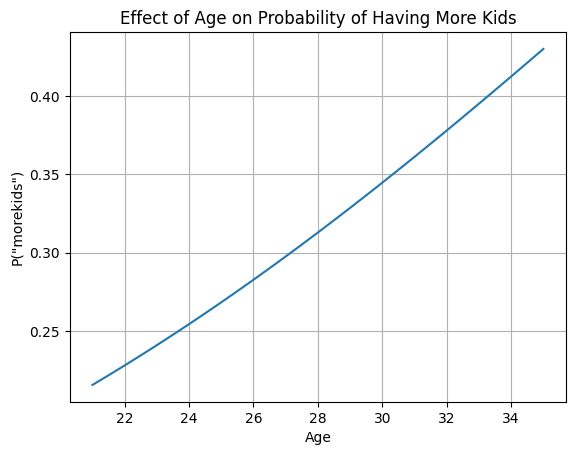

In [21]:
import matplotlib.pyplot as plt

# Plot results
plt.plot(plot_ages, plot_probs)
plt.xlabel('Age')
plt.ylabel('P("morekids")')
plt.title('Effect of Age on Probability of Having More Kids')
plt.grid(True)

### Checking for dependency of variables over each other (multicollinearity)

Two methods are used:
1. Correlation Matrix (S): Quick lookup of Rho in [-1, 1]
2. Variance Inflation Factor (VIF): how much a variable is explained by all the other variables in the model
  - VIF = 1: Not correlated
  - VIF 1-5: Moderately correlated
  - VIF > 5 (or 10): Highly correlated (p-values become unreliable)


Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

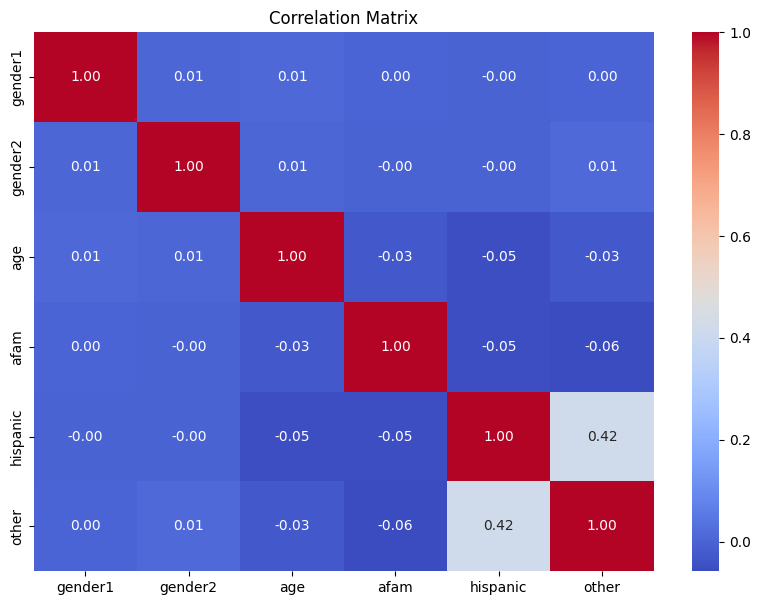

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X.corr()

# Plot as a heatmap so areas where strong positive correlation is present, we can identify as more red
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

VIF Score

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

vif_data = pd.DataFrame()
vif_data["variable"] = X_const.columns

# Calculate VIF for every variable
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

print(vif_data)

   variable        VIF
0     const  84.161507
1   gender1   1.000127
2   gender2   1.000384
3       age   1.003753
4      afam   1.005202
5  hispanic   1.218921
6     other   1.217714


## Stop Spark session

In [ ]:
spark.stop()